In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf

from IPython.display import display, HTML
display(HTML(""" <style> .output {display: center; align-items: left; text-align: center; justify-content: center; } </style> """))

In [2]:
#Importación de datos
#data = pd.read_excel('Generación Intermitente de la GCROC 2013-2019.xlsx', header=1)
data = pd.read_excel('plantas_intermitentes_clean.xlsx', header=1)
data.head()

,Unnamed: 0,dia_semana,fecha,hora,GICIE301,GICIE302,GICIE303,GICIE304,GICIE305,GICIS306,...,GICIS308,GICIS309,GICIS310,GICIS311,GICIS312,GICIS313,GICIS314,GICIS315,GICIS316,fecha_hora
0,1,jueves,2013-11-14,1,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 01:00:00
1,2,jueves,2013-11-14,2,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 02:00:00
2,3,jueves,2013-11-14,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 03:00:00
3,4,jueves,2013-11-14,4,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 04:00:00
4,5,jueves,2013-11-14,5,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 05:00:00


In [3]:
#LIMPIEZA DE DATOS
#Se elimina el primer día (14-11-2013) ya que muchas horas no tienen registro.
data = data.reset_index(level=None)
data = data.drop(range(0, 24),axis=0)
data = data.set_index(data['fecha_hora'])

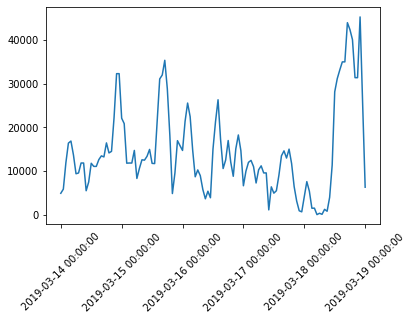

In [4]:
plt.plot(data['GICIE301'][-1-5*24:])
plt.xticks([0,24,48,72,96,120],rotation=45);

In [5]:
columns = ['GICIE301','GICIE302', 'GICIE303', 'GICIE304', 'GICIE305', 'GICIS306', 'GICIS307','GICIS308', 
           'GICIS309', 'GICIS310', 'GICIS311', 'GICIS312', 'GICIS313','GICIS314', 'GICIS315', 'GICIS316']

In [6]:
def mape(forecast, actual):
    return np.mean(np.abs((forecast - actual)/actual))  # MAPE

In [7]:
def AIC_accuracy(train,test):
    fcc = []
    for i in range(1,25):
        data = train['Hora '+str(i)].dropna()
        model = pm.auto_arima(data.values, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=4, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
        model.fit(data.values)
        #print(model)
        #model.plot_diagnostics(figsize=(7,5))
        #plt.show()
        # Predicción
        fc, confint = model.predict(n_periods=len(test), return_conf_int=True)
        fcc.append(fc)
    return(fcc, model)

In [9]:
def mape_prom_edited(columna):
    
    data2 = data[['hora','GICIE301']]
    data2['GICIE301'] = (data['GICIE301']+1) # para efectos de las tranformaciones logaritmicas(eliminar el 0)
    data2 = data2.dropna()

    #Se separará por hora del día, ya que cada hora se comporta diferente.
    xhr = pd.DataFrame() ; log = pd.DataFrame() ; rends = pd.DataFrame() ; rlogs = pd.DataFrame()
    ano,dia,hora= str(data2.index[1])[0:4], str(data2.index[1])[5:7] ,str(data2.index[1])[8:10]

    #El siguiente ciclo 'for' crea un DataFrame acomodado por horas, de cada planta de generación.
    for i in range(1,25):
        hrs = [data2.iloc[j][1] for j in range(len(data2)) if data2.iloc[j][0] == i ] #pd.Series()
        xhr['Hora '+str(i)] = hrs

    #Se va a trabajar con logaritmicos, porque esta transformación no afecta el vlaor, sino solo su rango.
    log = np.log(xhr)

    #Se le cambia el index a los DataFrame creados, por las fechas que son.
    xhr = xhr.set_index(pd.date_range(start=data['fecha'][0],end=data['fecha'][-1],freq='D'))

    #Seleccion de y_train y y_test
    test = (xhr.iloc[-5:,:])-1   # INFO DE TEST
    train = log.drop(log.index[1945:]) # QUITANDO TEST PARA TRAIN

    fcc = []

    #MODELO ARIMA
    for i in range(1,25):
        y_train = train['Hora '+str(i)].dropna()
        model = pm.auto_arima(y_train.values, start_p=1, start_q=1,
            test='adf',       # use adftest to find optimal 'd'
            max_p=5, max_q=4, # maximum p and q
            m=1,              # frequency of series
            d=None,           # let model determine 'd'
            seasonal=False)   # No Seasonality

        model.fit(y_train.values)
            #print(model)
            #model.plot_diagnostics(figsize=(7,5))
            #plt.show()
            # Predicción
        fc, confint = model.predict(n_periods=len(test), return_conf_int=True)
        fcc.append(fc)
    fc, model = AIC_accuracy(train,test)
    mapes = [mape(fc[i-1], np.log(test['Hora '+str(i)])) for i in range(1,25)]
    mapes = pd.DataFrame(mapes).dropna()
    mape_promedio = np.mean(mapes)
    dias = []
    for j in range(0,5):
        dias.append([np.exp([ fc[i][j] for i in range(len(fc))])][0])
    pronostico = pd.DataFrame(np.concatenate(dias))
    pronostico = pronostico.set_index(pd.date_range(pd.datetime(2019,3,14),periods=len(pronostico),freq='H'))
    pronostico.index = pronostico.index.map(str)

    arange_dates = []
    arange_no = []
    arange = data['GICIE301'][-1-19*24:].index
    for i in range(0,len(arange),48):
        arange_dates.append(arange[i])
        arange_no.append(i)

    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(data['GICIE301'][-1-19*24:], label = 'Datos Reales')
    plt.plot(pronostico, label='pronostico')
    plt.title('Predicción vs Reales 5 dias '+columna)
    plt.xticks(arange_no,arange_dates,rotation = 45)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    return mape_promedio, fc , model

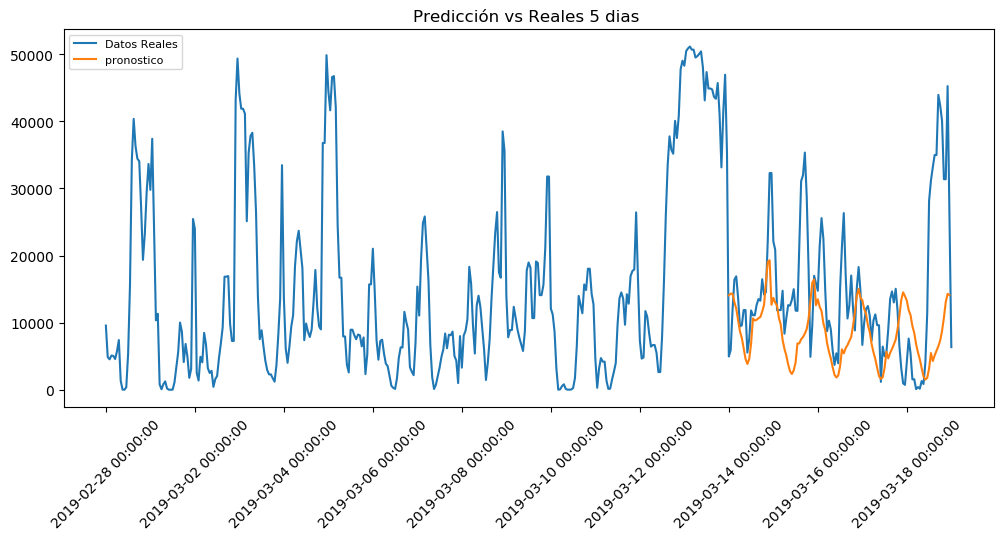

Toma 459.24057483673096 segundos


NameError: name 'speed' is not defined

In [14]:
import time
t1=time.time()
speed = []

prueba1 = [mape_prom_edited(columns[i]) for i in range(0,1)]
prueba1

t2 = time.time()
print("Toma {} segundos".format(t2-t1))
speed.append(t2-t1)

In [ ]:
eolicas = [mape_prom_edited(columns[i]) for i in range(0,5)]
eolicas

In [13]:
import time
t1=time.time()
speed = []

solares = [mape_prom_edited(columns[i]) for i in range(5,16)]

t2 = time.time()
print("Toma {} segundos".format(t2-t1))
speed.append(t2-t1)

solares

KeyboardInterrupt: 

In [ ]:
#La unica planta que no corre es GICIS312.

***

# PM.ARIMA TESTS:

https://alkaline-ml.com/pmdarima/usecases/sun-spots.html

In [300]:
log = np.log(xhr['Hora 1'])
log

2013-11-15    6.042633
2013-11-16    5.159055
2013-11-17    7.396335
2013-11-18    5.446737
2013-11-19    7.191429
                ...   
2019-03-14    8.683385
2019-03-15    9.946451
2019-03-16    9.970585
2019-03-17    9.212837
2019-03-18    8.938925
Freq: D, Name: Hora 1, Length: 1950, dtype: float64

In [301]:
train_len = 1940
y_train, y_test = train_test_split(log, train_size=train_len)
y_train

2013-11-15     6.042633
2013-11-16     5.159055
2013-11-17     7.396335
2013-11-18     5.446737
2013-11-19     7.191429
                ...    
2019-03-04     8.725994
2019-03-05    10.636744
2019-03-06     9.593628
2019-03-07     9.310186
2019-03-08     8.996404
Freq: D, Name: Hora 1, Length: 1940, dtype: float64

In [302]:
y_test

2019-03-09     8.963672
2019-03-10     9.325899
2019-03-11     5.673323
2019-03-12     8.441176
2019-03-13    10.829115
2019-03-14     8.683385
2019-03-15     9.946451
2019-03-16     9.970585
2019-03-17     9.212837
2019-03-18     8.938925
Freq: D, Name: Hora 1, dtype: float64

In [303]:
fit1 = pm.auto_arima(y_train, m=1, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=8180.662, BIC=8214.084, Time=1.494 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=8283.924, BIC=8295.065, Time=0.045 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=8189.197, BIC=8205.909, Time=0.171 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=8203.680, BIC=8220.392, Time=0.236 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=14326.574, BIC=14332.145, Time=0.026 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=8177.917, BIC=8205.769, Time=1.951 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=8187.791, BIC=8210.073, Time=0.271 seconds
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=8177.024, BIC=8199.305, Time=1.428 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=8178.258, BIC=8206.111, Time=1.763 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=8180.229, BIC=820

In [304]:
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1940
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -4084.512
Date:                Sun, 23 Feb 2020   AIC                           8177.024
Time:                        23:05:57   BIC                           8199.305
Sample:                             0   HQIC                          8185.218
                               - 1940                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.9127      0.553      7.070      0.000       2.828       4.997
ar.L1          0.5877      0.059     10.040      0.000       0.473       0.702
ma.L1         -0.3910      0.065     -6.001      0.000      -0.519      -0.263
sigma2         3.9464      0.096     41.284      0.000       3.759       4.134
===================================================================================
Ljung-Box (Q):                       46.31   Jarque-Bera (JB):             13353.32
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -3.10
Prob(H) (two-sided):                  0.10   Kurtosis:                        14.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

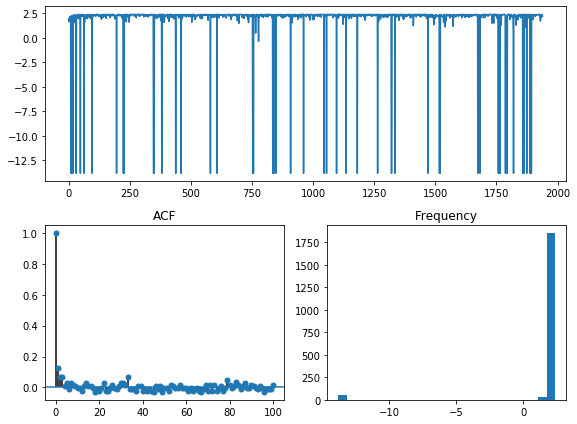

In [305]:
from pmdarima.preprocessing import LogEndogTransformer

y_train_log, _ = LogEndogTransformer(lmbda=1e-6).fit_transform(y_train)
tsdisplay(y_train_log, lag_max=100)

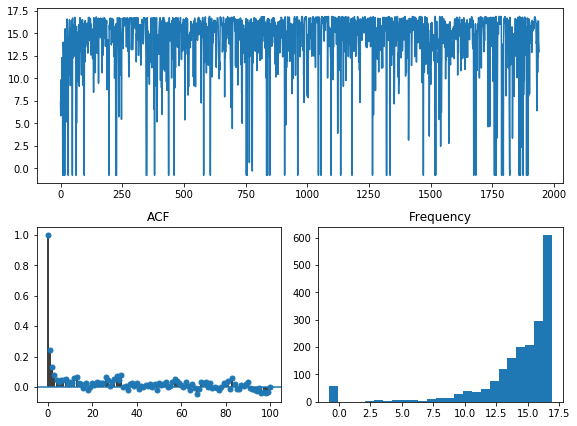

In [306]:
from pmdarima.preprocessing import BoxCoxEndogTransformer

y_train_bc, _ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(y_train)
tsdisplay(y_train_bc, lag_max=100)

In [307]:
from scipy.stats import normaltest
normaltest(y_train_bc)[1]
# 2.5138201352932145e-41

1.581043749214375e-235

In [308]:
from pmdarima.pipeline import Pipeline

fit2 = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=12))
])

fit2.fit(y_train)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(1, 0, 1, 12) (constant=True); AIC=10400.143, BIC=10444.707, Time=9.077 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 12) (constant=True); AIC=10393.557, BIC=10404.698, Time=0.044 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 0, 12) (constant=True); AIC=10278.064, BIC=10300.345, Time=2.189 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 1, 12) (constant=True); AIC=10296.701, BIC=10318.982, Time=1.022 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 12) (constant=False); AIC=15909.375, BIC=15914.945, Time=0.025 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 12) (constant=True); AIC=10279.709, BIC=10296.421, Time=0.165 seconds
Fit ARIMA: (1, 0, 0)x(2, 0, 0, 12) (constant=True); AIC=10279.663, BIC=10307.516, Time=9.766 seconds
Fit ARIMA: (1, 0, 0)x(1, 0, 1, 12) (constant=True); AIC=10283.688, BIC=10311.540, Time=4.114 seconds
Near non-invertible roots for order (1, 0, 0)(1, 0, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circ

Pipeline(steps=[('boxcox',
                 BoxCoxEndogTransformer(floor=1e-16, lmbda=None, lmbda2=1e-06,
                                        neg_action='raise')),
                ('arima',
                 AutoARIMA(D=None, alpha=0.05, d=None, error_action='warn',
                           information_criterion='aic', m=12, max_D=1, max_P=2,
                           max_Q=2, max_d=2, max_order=5, max_p=5, max_q=5,
                           maxiter=50, method='lbfgs', n_fits=10, n_jobs=1,
                           offset_test_args=None, out_of_sample_size=0,
                           random=False, random_state=None, scoring='mse',
                           scoring_args=None, seasonal=True,
                           seasonal_test='ocsb', seasonal_test_args=None,
                           start_P=1, start_Q=1, start_p=2, start_params=None, ...))])

In [309]:
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1940
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood               -5127.502
Date:                             Sun, 23 Feb 2020   AIC                          10265.004
Time:                                     23:08:59   BIC                          10292.857
Sample:                                          0   HQIC                         10275.247
                                            - 1940                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.7097      0.778      7.337      0.000       4.184       7.235
ar.L1          0.5790      0.057     10.086      0.000       0.466       0.692
ma.L1         -0.3653      0.064     -5.672      0.000      -0.491      -0.239
ar.S.L12       0.0424      0.020      2.089      0.037       0.003       0.082
sigma2        11.5664      0.294     39.337      0.000      10.990      12.143
===================================================================================
Ljung-Box (Q):                       49.75   Jarque-Bera (JB):              6984.77
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -2.54
Prob(H) (two-sided):                  0.10   Kurtosis:                        10.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [310]:
forecast = fit2.predict(10)
forecast

array([9.43847687, 9.41273775, 9.37391612, 9.50897899, 9.60677705,
       9.50083666, 9.62221021, 9.54301054, 9.62548052, 9.58130539])

In [311]:
y_test

2019-03-09     8.963672
2019-03-10     9.325899
2019-03-11     5.673323
2019-03-12     8.441176
2019-03-13    10.829115
2019-03-14     8.683385
2019-03-15     9.946451
2019-03-16     9.970585
2019-03-17     9.212837
2019-03-18     8.938925
Freq: D, Name: Hora 1, dtype: float64

In [330]:
from sklearn.metrics import mean_squared_error as mse


def plot_forecasts(forecasts, title, figsize=(8, 12)):
    x = np.arange(y_train.shape[0] + forecasts.shape[0])

    fig, axes = plt.subplots(2, 1, sharex=False, figsize=figsize)

    # Plot the forecasts
    axes[0].plot(x[:y_train.shape[0]], y_train, c='b')
    axes[0].plot(x[y_train.shape[0]:], forecasts, c='g')
    axes[0].set_xlabel(f'Sunspots (RMSE={np.sqrt(mse(y_test, forecasts)):.3f})')
    axes[0].set_title(title)

    # Plot the residuals
    #resid = y_test - forecasts
    #_, p = normaltest(resid)
    #axes[1].hist(resid, bins=15)
    #axes[1].axvline(0, linestyle='--', c='r')
    #axes[1].set_title(f'Residuals (p={p:.3f})')

    plt.tight_layout()
    plt.show()

In [331]:
# Comando para interactuar con las gráficas
#%matplotlib notebook

# Comando para no interactuar mas con las gráficas
%matplotlib inline

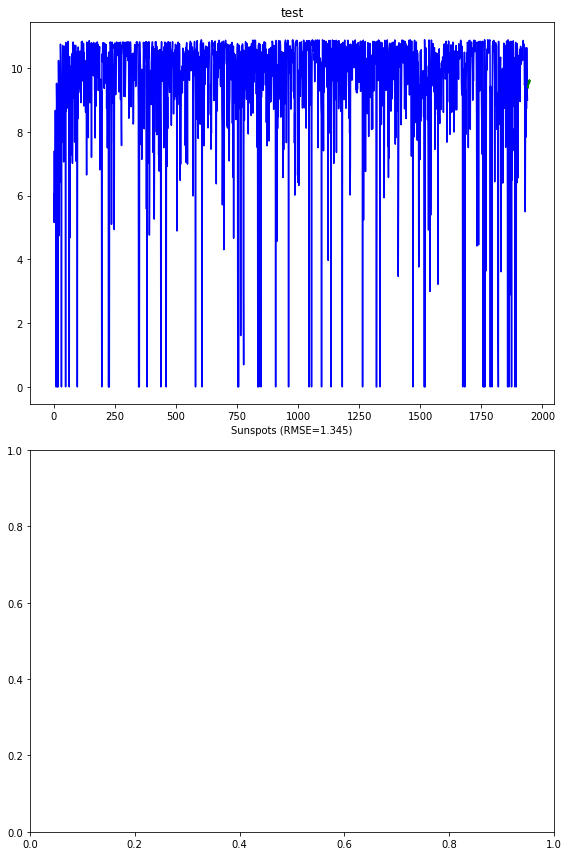

In [332]:
plot_forecasts(forecast,"test")

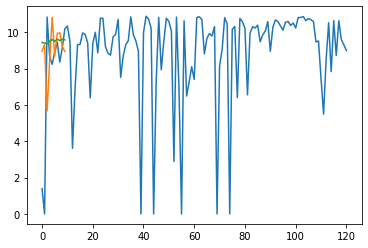

In [342]:
plt.plot(y_train.values[-1-5*24:])
plt.plot(y_test.values)
plt.plot(forecast)

***